In [1]:
import numpy as np
from mistdata import cal_s11 as cal
from cmt_vna import VNA, S11
import matplotlib.pyplot as plt
from cmt_vna import S911T
import os
%matplotlib widget

In [2]:
#fake freqs
fake_freqs = np.linspace(50e6, 250e6, 1001)

#Testing the calkit values. It's fine.
calkit = S911T(freq_Hz = fake_freqs)

In [3]:
#testing that my polyval works
c_coefs = (6.18E-45, -226E-36, 2470E-27, -7.425E-15)
c_polyval = np.polyval(c_coefs, fake_freqs)
c_open = -7.425E-15 + 2470E-27 * fake_freqs - 226E-36 * fake_freqs**2 + 6.18E-45 * fake_freqs**3
np.allclose(c_open, c_polyval)

True

In [4]:
#testing that I can reproduce the gamma with c_open
c_delay = 30.821e-12 #s
c_loss = 2e9 #Ohm/s
Z0 = 50

Z_off_open = Z0 + (1-1j) * c_loss / (4 * np.pi * fake_freqs) * np.sqrt(fake_freqs/1e9)
gamma_off_open = cal.impedance_to_gamma(Z_off_open, Z0)
Z_ter_open = -1j / (2 * np.pi * fake_freqs * c_open)
gamma_ter_open = cal.impedance_to_gamma(Z_ter_open, Z0)

g_l_open = 1j * 2 * np.pi * fake_freqs * c_delay + (1+1j) * c_delay * c_loss / (2 * Z0) * np.sqrt(fake_freqs/1e9)

gamma_open = gamma_off_open * (1 - np.exp(-2 * g_l_open) - gamma_off_open * gamma_ter_open) + gamma_ter_open * np.exp(-2 * g_l_open)
gamma_open /= 1 - gamma_off_open * (np.exp(-2 * g_l_open) * gamma_off_open + gamma_ter_open * (1 - np.exp(-2 * g_l_open)))

print(np.allclose(calkit.open.gamma_ter, gamma_ter_open))
print(np.allclose(calkit.open.gamma_off, gamma_off_open))
print(np.allclose(calkit.open.gamma, gamma_open))

True
True
True


In [5]:
l_coefs = (-6.13E-42,303.8E-33, -5010E-24, 27.98E-12)
l_polyval = np.polyval(c_coefs, fake_freqs)
l_short = 27.98e-12 - 5010E-24 * fake_freqs + 303.8E-33 * fake_freqs**2 - 6.13E-42 * fake_freqs**3
np.allclose(l_short, l_polyval)

True

In [6]:
#testing I can reproduce gamma with l_short
l_delay = 30.688E-12 #s
l_loss = 2E9 #Ohm/s

Z_off_short = Z0 + (1-1j) * l_loss / (4 * np.pi * fake_freqs) * np.sqrt(fake_freqs/1e9)
gamma_off_short = cal.impedance_to_gamma(Z_off_short, Z0)
Z_ter_short = 1j * 2 * np.pi * fake_freqs * l_short
gamma_ter_short = cal.impedance_to_gamma(Z_ter_short, Z0)

g_l_short = 1j * 2 * np.pi * fake_freqs * l_delay + (1+1j) * l_delay * l_loss / (2 * Z0) * np.sqrt(fake_freqs/1e9)

gamma_short = gamma_off_short * (1 - np.exp(-2 * g_l_short) - gamma_off_short * gamma_ter_short) + gamma_ter_short * np.exp(-2 * g_l_short)
gamma_short /= 1 - gamma_off_short * (np.exp(-2 * g_l_short) * gamma_off_short + gamma_ter_short * (1 - np.exp(-2 * g_l_short)))

print(np.allclose(calkit.short.gamma_ter, gamma_ter_short))
print(np.allclose(calkit.short.gamma_off, gamma_off_short))
print(np.allclose(calkit.short.gamma, gamma_short))

True
True
True


# Now I know my standards work!
### That was deeply embarrassing actually.

Let's forget it happened and test to see if my sparams stuff makes sense.

If the measured standards are the same as the model standards, then my s params
should be perfecto, so that's first.

In [7]:
load_Z = 50 #Ohm
z_load = np.ones(len(fake_freqs)) * load_Z
gamma_load = cal.impedance_to_gamma(z_load, Z0)
fake_stds_meas = np.vstack([gamma_open, gamma_short, gamma_load])

test_sparams = calkit.sparams(stds_meas = fake_stds_meas)

np.allclose(fake_stds_meas, calkit.std_gamma) #standards are the same

True

In [8]:
s11 = test_sparams[0] #Should be 0
s12S21 = test_sparams[1] #Should be 1
s22 = test_sparams[2] #Should be 0

In [9]:
print(np.allclose(s11, 0))
print(np.allclose(s12S21, 1))
print(np.allclose(s22, 0))

True
True
True


# Given some S parameters...
Can I take a measured gamma and turn it into an intrinsic (de-embed)?
1. Measured gamma = models, sparams = perfect through => should get intrinsic = measured = models.

Can I take an intrinsic gamma and turn it into a measured gamma (embed)?
1. Intrinsic = models, sparams = perfect through => measured = models.
2. Intrinsic = models, sparams = stops => measured = 0.

Combine them!
1. Get a set of sparams! *The VNA ones I calculated*.
2. Embed the sparams into the model gammas. 
3. Can I get the right sparams out?
4. Can I get the model gammas back out of the embedded ones?

In [10]:
#Using fake_stds_meas for meas
###DE-EMBED PERFECT THRU SPARAMS###
Nfreq = len(fake_freqs)
thru_sparams = np.empty((3, Nfreq), dtype=complex)
thru_sparams[0] = 0 #S11
thru_sparams[1] = 1 #S12S21
thru_sparams[2] = 0 #S22

de_embedded_through_sparams = cal.de_embed_sparams(sparams=thru_sparams, gamma_prime=fake_stds_meas)
print(np.allclose(de_embedded_through_sparams, calkit.std_gamma))

True


In [11]:
###EMBED PERFECT THROUGH INTO MODEL PRMS###
embedded_thru_prms = cal.embed_sparams(sparams=thru_sparams, gamma=calkit.std_gamma)
print(np.allclose(embedded_thru_prms, fake_stds_meas))

###EMBED PERFECT STOP###
stop_sparams = np.empty((3, Nfreq), dtype=complex)
stop_sparams[0] = 1 #S11
stop_sparams[1] = 0 #S1221
stop_sparams[2] = 1 #S22

embedded_stop_prms = cal.embed_sparams(sparams=stop_sparams, gamma=calkit.std_gamma)
#This should be one across the board! Because it's a full stop
print(np.allclose(embedded_stop_prms, 1))

True
True


In [12]:
os.getcwd()

'/Users/cgtolley/Desktop/elsie/CMT-VNA/tests'

In [13]:
###COMBINE THE THINGS!###
#first, retrieve vna prms from model meas
DATA_DIR = '../data/'

CAL_DIR = os.path.join(DATA_DIR, 'cals')
CAL_FILE = os.path.join(CAL_DIR, min(os.listdir(CAL_DIR)))
CAL = np.load(CAL_FILE)
FREQS = CAL['freqs']
osl = np.vstack([CAL['open'], CAL['short'], CAL['load']])

calkit = S911T(freq_Hz=FREQS) #new calkit with meas freqs

vna_sprms = cal.network_sparams(gamma_true=calkit.std_gamma, gamma_meas=osl) #vna_prms acquired

#embed now into models
test_meas = cal.embed_sparams(sparams=vna_sprms, gamma=calkit.std_gamma)

#Now we can take test_meas and std_gamma and try to get out the sparams again
retrieved_sprms = cal.network_sparams(gamma_true=calkit.std_gamma, gamma_meas = test_meas)
print(np.allclose(retrieved_sprms, vna_sprms))

#Now can take vna_sprms and osl and get the model out
retrieved_gamma_true = cal.de_embed_sparams(sparams=vna_sprms, gamma_prime=osl)
print(np.allclose(retrieved_gamma_true, calkit.std_gamma))

True
True


# Nice!

Now let's make sure the VNA add_sparams func works as well.

In [14]:
test_file = S11()
calkit = S911T(freq_Hz=FREQS)
test_file.from_file(CAL_FILE, network = 'vna')

no sparam data.


In [15]:
test_file.add_sparams(network='vna', stds_meas=test_file.stds['vna'])

In [16]:
np.allclose(test_file.sparams['vna'], vna_sprms)

True

# Checking the loads
I put a 50 Ohm load across two differential signal paths. Here's what came out.

In [17]:
DATADIR = '../data/'

load_dir = os.path.join(DATADIR, 'unit_tests')
load_cals_dir = os.path.join(load_dir, 'cals')
cals_after_balun_file = os.path.join(load_cals_dir, os.listdir(load_cals_dir)[0])
cals_after_balun = np.array([np.load(cals_after_balun_file)['open'], np.load(cals_after_balun_file)['short'], np.load(cals_after_balun_file)['load']])

cals_at_vna_file = DATADIR + 'cals/20250321_151142_calibration.npz'
cals_at_vna = np.array([np.load(cals_at_vna_file)['open'], np.load(cals_at_vna_file)['short'], np.load(cals_at_vna_file)['load']])

load = np.load(os.path.join(load_dir, '20250321_144632.npz'))['gamma']
freqs = np.load(os.path.join(load_dir, '20250321_144632.npz'))['freqs']

calkit = S911T(freq_Hz=freqs)

/var/folders/cy/tyk8jd852vb0cz42dfbv8tvr0000gn/T/ipykernel_83483/2427852947.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(20*np.log10(np.abs(model_stds[2])), label='Load')


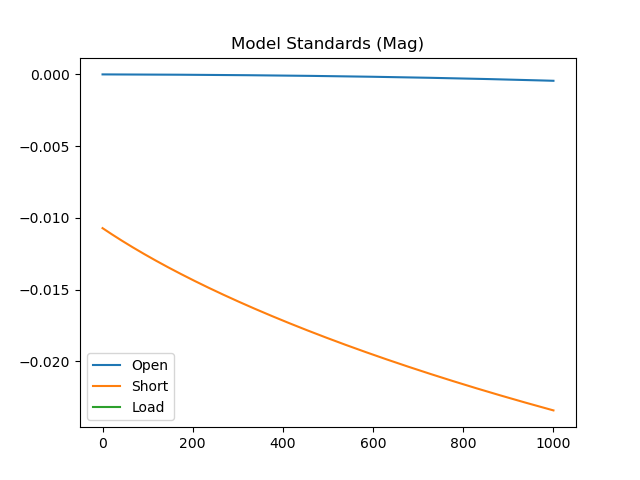

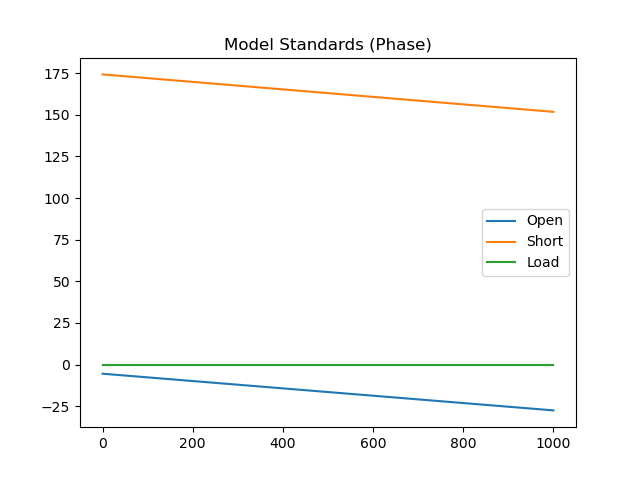

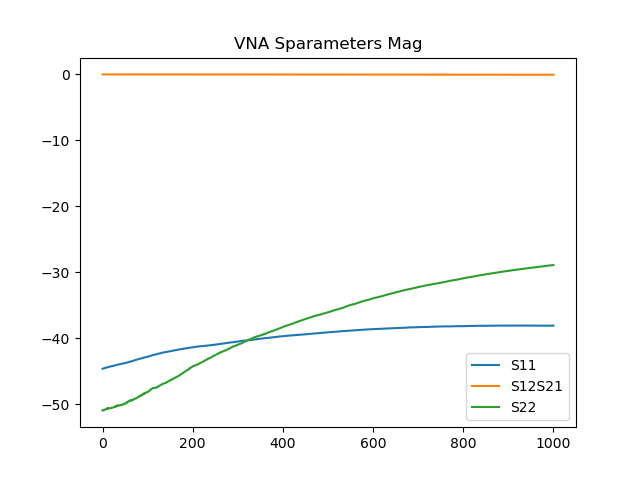

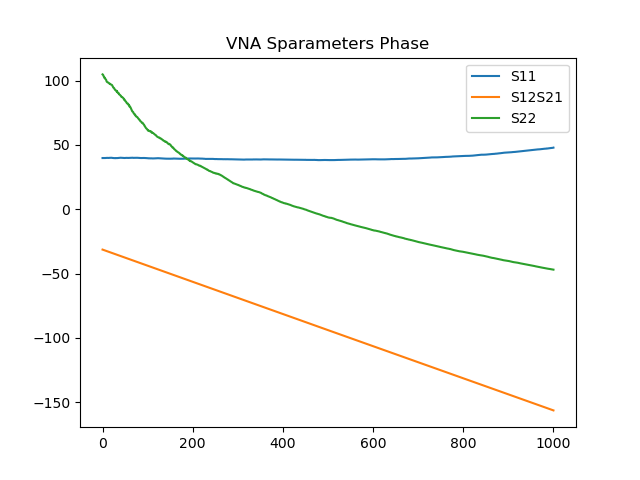

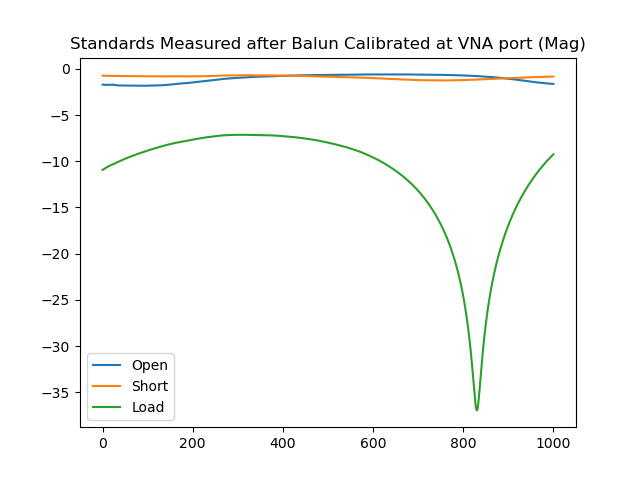

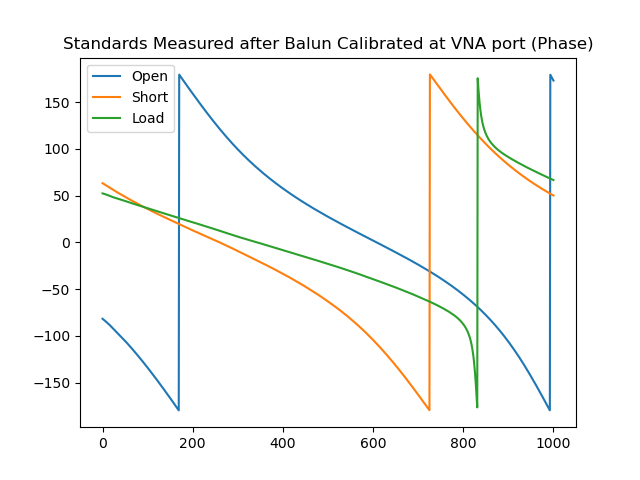

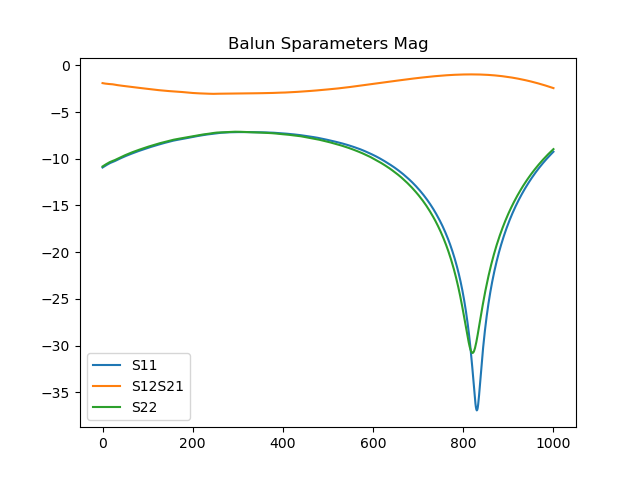

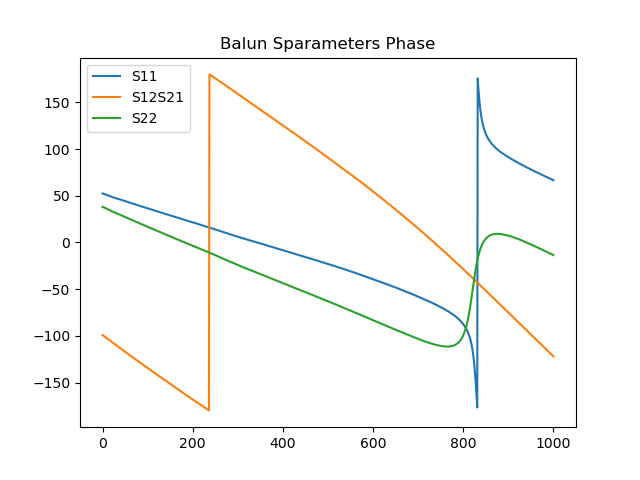

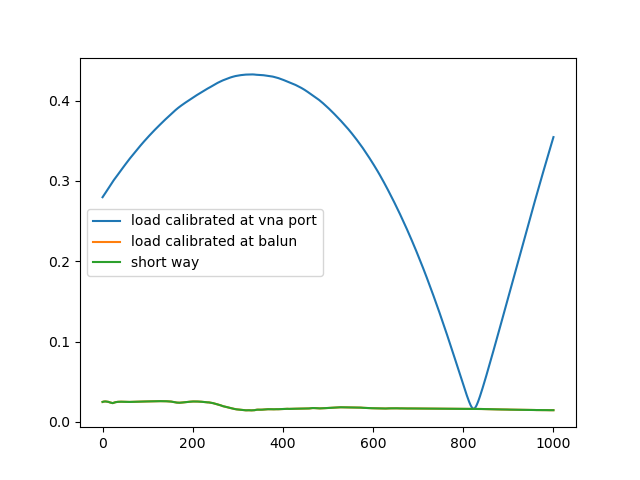

In [77]:
model_stds = calkit.std_gamma

plt.figure()
plt.plot(20*np.log10(np.abs(model_stds[0])), label='Open')
plt.plot(20*np.log10(np.abs(model_stds[1])), label='Short')
plt.plot(20*np.log10(np.abs(model_stds[2])), label='Load')
plt.legend()
plt.title('Model Standards (Mag)')
plt.show()

plt.figure()
plt.plot(np.angle(model_stds[0], deg=True), label='Open')
plt.plot(np.angle(model_stds[1], deg=True), label='Short')
plt.plot(np.angle(model_stds[2], deg=True), label='Load')

plt.legend()
plt.title('Model Standards (Phase)')
plt.show()

vna_sparams = cal.network_sparams(gamma_true=model_stds, gamma_meas=cals_at_vna)

plt.figure()
plt.plot(20*np.log10(np.abs(vna_sparams[0])), label='S11')
plt.plot(20*np.log10(np.abs(vna_sparams[1])), label='S12S21')
plt.plot(20*np.log10(np.abs(vna_sparams[2])), label='S22')
plt.legend()
plt.title('VNA Sparameters Mag')
plt.show()

plt.figure()
plt.plot(np.angle(vna_sparams[0], deg=True), label='S11')
plt.plot(np.angle(vna_sparams[1], deg=True), label='S12S21')
plt.plot(np.angle(vna_sparams[2], deg=True), label='S22')

plt.legend()
plt.title('VNA Sparameters Phase')
plt.show()

stds_after_balun_cal_at_vna = cal.de_embed_sparams(sparams=vna_sparams, gamma_prime=cals_after_balun)

plt.figure()
plt.plot(20*np.log10(np.abs(stds_after_balun_cal_at_vna[0])), label='Open')
plt.plot(20*np.log10(np.abs(stds_after_balun_cal_at_vna[1])), label='Short')
plt.plot(20*np.log10(np.abs(stds_after_balun_cal_at_vna[2])), label='Load')
plt.legend()
plt.title('Standards Measured after Balun Calibrated at VNA port (Mag)')
plt.show()

plt.figure()
plt.plot(np.angle(stds_after_balun_cal_at_vna[0], deg=True), label='Open')
plt.plot(np.angle(stds_after_balun_cal_at_vna[1], deg=True), label='Short')
plt.plot(np.angle(stds_after_balun_cal_at_vna[2], deg=True), label='Load')

plt.legend()
plt.title('Standards Measured after Balun Calibrated at VNA port (Phase)')
plt.show()
# plt.figure()
# plt.plot(np.angle(stds_after_balun_cal_at_vna[0], deg=True), label='S11')
# plt.plot(np.angle(stds_after_balun_cal_at_vna[1], deg=True), label='S12S21')
# plt.plot(np.angle(stds_after_balun_cal_at_vna[2], deg=True), label='S22')

# plt.legend()
# plt.title('VNA Sparameters Phase')
# plt.show()

balun_sprms = cal.network_sparams(gamma_true=model_stds, gamma_meas=stds_after_balun_cal_at_vna)

plt.figure()
plt.plot(20*np.log10(np.abs(balun_sprms[0])), label='S11')
plt.plot(20*np.log10(np.abs(balun_sprms[1])), label='S12S21')
plt.plot(20*np.log10(np.abs(balun_sprms[2])), label='S22')
plt.legend()
plt.title('Balun Sparameters Mag')
plt.show()

plt.figure()
plt.plot(np.angle(balun_sprms[0], deg=True), label='S11')
plt.plot(np.angle(balun_sprms[1], deg=True), label='S12S21')
plt.plot(np.angle(balun_sprms[2], deg=True), label='S22')

plt.legend()
plt.title('Balun Sparameters Phase')
plt.show()

#calibrate the load measurement now
load_at_vna = cal.de_embed_sparams(sparams=vna_sparams, gamma_prime=load)
load_at_balun_long_way = cal.de_embed_sparams(sparams=balun_sprms, gamma_prime=load_at_vna)

#calibrate load measurement short way
sprms_full_system = cal.network_sparams(gamma_true=model_stds, gamma_meas=cals_after_balun)

# plt.figure()
# plt.plot(np.abs(sprms_full_system[0]), label='S11')
# plt.plot(np.abs(sprms_full_system[1]), label='S12S21')
# plt.plot(np.abs(sprms_full_system[2]), label='S22')
# plt.legend()
# plt.title('Full System Sparameters')
# plt.show()

load_after_full_system = cal.de_embed_sparams(sparams=sprms_full_system, gamma_prime=load)

plt.figure()
plt.plot(np.abs(load_at_vna), label='load calibrated at vna port')
plt.plot(np.abs(load_at_balun_long_way), label='load calibrated at balun')
plt.plot(np.abs(load_after_full_system), label='short way')
plt.legend()
plt.show()

In [75]:
plt.close('all')